In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
np.random.seed(125)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# Functions
def convert_to_one_hot(Y, C):
  Y = np.eye(C)[Y.reshape(-1)]
  return Y

# for padding
def fix(arr,pad_s = 50):
  dif = pad_s - arr.shape[0]
  temp = np.concatenate((arr, np.zeros((dif,512))))
  return temp

def acc_plot(history):
  # summarize history for accuracy
  print()
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def loss_plot(history):
  # summarize history for loss
  print()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


**Embeddings from google sentence encoder**

## Dataset Preview

In [15]:
dic = {'fake':1,'reliable':0}
df = pd.read_csv('drive/My Drive/CSV/clean_fake_reliable.csv')[['type','content','title']]
df['type'] = df['type'].apply(lambda x: dic[x])
df['sent_c'] = df['content'].astype(str).apply(sent_tokenize).apply(len)
df.head()


,type,content,title,sent_c
0,1,"Quite frankly, I’m surprised it has half left....",Surprise: Socialist Hotbed Of Venezuela Has Lo...,16
1,1,"If You Are Upset About Being Called Fake News,...",Water Cooler date Open Thread; Fake News ? CNN...,17
2,1,Let’s be honest: This is pretty much all of Fo...,Veteran Commentator Calls Out the Growing “Eth...,18
3,1,"Let me tell you something, about otters and mo...","Lost Words, Hidden Words, Otters, Banks and Books",42
4,1,Never mind transportation and power generation...,Why Sandwiches Must Be Banned,9


In [16]:
print('Real\tFake\n{}\t{}'.format(df['type'].value_counts()[0],df['type'].value_counts()[1]))

Real	Fake
6724	6162


## Google Embeddings 

In [0]:
# Article Embeddings made from Google Universal Sentence Encoder
real_art = np.load('drive/My Drive/CSV/emb/open_source/real_art_emb.npy')[:5899]
fake_art = np.load('drive/My Drive/CSV/emb/open_source/fake_art_emb.npy')[:5199]
data = np.concatenate((real_art,fake_art),axis=0)
print('Type\tCounts\n{}\t{}\n{}\t{}'.format('Real',len(real_art),'Fake',len(fake_art)))

Type	Counts
Real	5899
Fake	5199


In [0]:
# Contains Total of 11098 articles 
# Each article has maximum of 50 Sentences (which are padded if less)
# Each sentence is represented by a vector of size (512,) 
data.shape

(11098, 50, 512)

In [0]:
# One hot representation of Labels
Y = convert_to_one_hot(np.append(np.zeros((5899,),dtype=int),np.ones((5199,),dtype=int)),2) # reliable [1,0] fake [0,1]
print(Y[0],Y[5900],sep='\n')

[1. 0.]
[0. 1.]


### **Train - Test**

In [0]:
# Train Test
xTrain, xTest, yTrain, yTest = train_test_split(data, Y, test_size = 0.2, random_state = 125)

In [0]:
# First 5 labels 
yTest[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [0]:
print("Train Size - {}, Test size - {} ".format(yTrain.shape[0],yTest.shape[0]))

Train Size - 8878, Test size - 2220 


In [0]:
yTest[0]

True

In [0]:
xTrain.shape

(8878, 50, 512)

In [0]:
# Will be used in callbacks in keras model.fit
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

## **Model v1**
Simple Single Layer LSTM followed by a dense layer.
- LSTM layer takes input a 3d vector which has 50 timesteps, 512 Features, 1 or more samples
- LSTM layer is the input layer in this case
- Embeddings are directly fed into it.

In [0]:
modelv1 = Sequential()
modelv1.add(LSTM(256, input_shape=(50, 512), return_sequences=False,activity_regularizer=l1(0.0001)))
modelv1.add(Dropout(0.5))
modelv1.add(Dense(2, activation='softmax'))
modelv1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelv1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 787,970
Trainable params: 787,970
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history_v1 = modelv1.fit(xTrain, yTrain, epochs=5, validation_data=(xTest, yTest), batch_size=64,validation_split=0.2, callbacks = [es])

Train on 8878 samples, validate on 2220 samples
Epoch 1/5
8878/8878 [==============================] - 22s 2ms/step - loss: 0.4762 - acc: 0.8054 - val_loss: 0.4126 - val_acc: 0.8563
Epoch 2/5
8878/8878 [==============================] - 21s 2ms/step - loss: 0.3793 - acc: 0.8670 - val_loss: 0.3725 - val_acc: 0.8734
Epoch 3/5
8878/8878 [==============================] - 21s 2ms/step - loss: 0.3428 - acc: 0.8784 - val_loss: 0.3247 - val_acc: 0.8838
Epoch 4/5
8878/8878 [==============================] - 21s 2ms/step - loss: 0.3089 - acc: 0.8900 - val_loss: 0.2835 - val_acc: 0.9059
Epoch 5/5
8878/8878 [==============================] - 21s 2ms/step - loss: 0.2740 - acc: 0.9090 - val_loss: 0.2548 - val_acc: 0.9104


In [0]:
loss, acc = modelv1.evaluate(xTest, yTest)
print()
print("Test accuracy = ", acc)

2220/2220 [==============================] - 4s 2ms/step

Test accuracy =  0.9103603603603604


## **Model v2**
- Double layered LSTM with dropout and dense.


In [0]:
# MODEl v2
# Change number of units in LSTM 
modelv2 = Sequential()
modelv2.add(LSTM(256, input_shape=(50, 512), return_sequences=True))
modelv2.add(Dropout(0.5)) # change to see different results
modelv2.add(LSTM(256, input_shape=(50, 512), return_sequences=False,activity_regularizer=l1(0.0001)))
modelv2.add(Dropout(0.5))
modelv2.add(Dense(2, activation='softmax')) # check softmax or other function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
#adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
modelv2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(modelv2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 256)           787456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 1,313,282
Trainable params: 1,313,282
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
historyv2 = modelv2.fit(xTrain, yTrain, epochs=5, validation_data=(xTest, yTest), validation_split=0.2, batch_size=64)

Train on 8878 samples, validate on 2220 samples
Epoch 1/5
8878/8878 [==============================] - 42s 5ms/step - loss: 0.4865 - acc: 0.8075 - val_loss: 0.3871 - val_acc: 0.8649
Epoch 2/5
8878/8878 [==============================] - 40s 5ms/step - loss: 0.3828 - acc: 0.8646 - val_loss: 0.3613 - val_acc: 0.8779
Epoch 3/5
8878/8878 [==============================] - 40s 5ms/step - loss: 0.3427 - acc: 0.8773 - val_loss: 0.3443 - val_acc: 0.8761
Epoch 4/5
8878/8878 [==============================] - 40s 5ms/step - loss: 0.3186 - acc: 0.8885 - val_loss: 0.3020 - val_acc: 0.8874
Epoch 5/5
8878/8878 [==============================] - 40s 5ms/step - loss: 0.2809 - acc: 0.9047 - val_loss: 0.2619 - val_acc: 0.9126
CPU times: user 4min 11s, sys: 31.5 s, total: 4min 43s
Wall time: 3min 26s


In [0]:
loss, acc = modelv2.evaluate(xTest, yTest)
print()
print('Test Accuracy : {}\nLoss : {}'.format(acc,loss))

2220/2220 [==============================] - 8s 4ms/step

Test Accuracy : 0.9126126126126126
Loss : 0.24418269951601287


## **Model v3**
- Added conv layer on top of LSTM stack. layer 1 learns more spatial relationship. Architecture after this is same as model v1.

In [0]:
modelv3 = Sequential()
modelv3.add(Conv1D(input_shape=(50, 512),filters=512, kernel_size=3, padding='same', activation='relu'))
modelv3.add(MaxPooling1D(pool_size=2))
modelv3.add(LSTM(256, input_shape=(50, 512), return_sequences=False,activity_regularizer=l1(0.0001)))
modelv3.add(Dropout(0.5))
modelv3.add(Dense(2, activation='softmax'))
modelv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelv3.summary())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 512)           786944    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 1,574,914
Trainable params: 1,574,914
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
historyv3 = modelv3.fit(xTrain, yTrain, epochs=5, validation_data=(xTest, yTest), batch_size=64, validation_split=0.2, callbacks = [es])

Train on 8878 samples, validate on 2220 samples
Epoch 1/5
8878/8878 [==============================] - 18s 2ms/step - loss: 0.4156 - acc: 0.8518 - val_loss: 0.3108 - val_acc: 0.9014
Epoch 2/5
8878/8878 [==============================] - 14s 2ms/step - loss: 0.2318 - acc: 0.9350 - val_loss: 0.2407 - val_acc: 0.9293
Epoch 3/5
8878/8878 [==============================] - 14s 2ms/step - loss: 0.1537 - acc: 0.9655 - val_loss: 0.2214 - val_acc: 0.9320
Epoch 4/5
8878/8878 [==============================] - 14s 2ms/step - loss: 0.1223 - acc: 0.9774 - val_loss: 0.2123 - val_acc: 0.9414
Epoch 5/5
8878/8878 [==============================] - 14s 2ms/step - loss: 0.0977 - acc: 0.9843 - val_loss: 0.2270 - val_acc: 0.9383
CPU times: user 1min 23s, sys: 11.2 s, total: 1min 34s
Wall time: 1min 15s


In [0]:
loss, acc = modelv3.evaluate(xTest, yTest)
print()
print('Test accuracy : {} \nLoss : {}'.format(acc,loss))

2220/2220 [==============================] - 3s 1ms/step

Test accuracy : 0.9382882882882883 
Loss : 0.20796732774994395


## **Model v4**

- Added conv layer as input layer.. after which RNN.. v2

In [0]:
modelv4 = Sequential()
modelv4.add(Conv1D(input_shape=(50, 512),filters=512, kernel_size=3, padding='same', activation='relu'))
modelv4.add(MaxPooling1D(pool_size=2))
modelv4.add(LSTM(512, input_shape=(50, 512), return_sequences=True))
modelv4.add(Dropout(0.5)) # change to see different results
modelv4.add(LSTM(512, input_shape=(50, 512), return_sequences=False, activity_regularizer=l1(0.0001)))
modelv4.add(Dropout(0.5))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
#adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
modelv4.add(Dense(2, activation='softmax')) # check softmax or other function
modelv4.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])
print(modelv4.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 50, 512)           786944    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 25, 512)           2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 512)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total para

In [0]:
%%time
historyv4 = modelv4.fit(xTrain, yTrain, epochs=5, validation_data=(xTest, yTest), batch_size=64, validation_split=0.2, callbacks = [es])

Train on 8878 samples, validate on 2220 samples
Epoch 1/5
8878/8878 [==============================] - 29s 3ms/step - loss: 0.4015 - acc: 0.8629 - val_loss: 0.2928 - val_acc: 0.9144
Epoch 2/5
8878/8878 [==============================] - 27s 3ms/step - loss: 0.2279 - acc: 0.9412 - val_loss: 0.2791 - val_acc: 0.9077
Epoch 3/5
8878/8878 [==============================] - 27s 3ms/step - loss: 0.1639 - acc: 0.9636 - val_loss: 0.2134 - val_acc: 0.9392
Epoch 4/5
8878/8878 [==============================] - 27s 3ms/step - loss: 0.1225 - acc: 0.9779 - val_loss: 0.2193 - val_acc: 0.9387
Epoch 5/5
8878/8878 [==============================] - 27s 3ms/step - loss: 0.1041 - acc: 0.9831 - val_loss: 0.2016 - val_acc: 0.9432
CPU times: user 2min 38s, sys: 23.5 s, total: 3min 2s
Wall time: 2min 18s


In [0]:
loss, acc = modelv4.evaluate(xTest, yTest)
print()
print('Test accuracy = {} \n loss - {}'.format(acc,loss))

2220/2220 [==============================] - 5s 2ms/step

Test accuracy = 0.9432432432432433 
 loss - 0.18276223479224754


## **Results and Evaluation**

### Modelv1

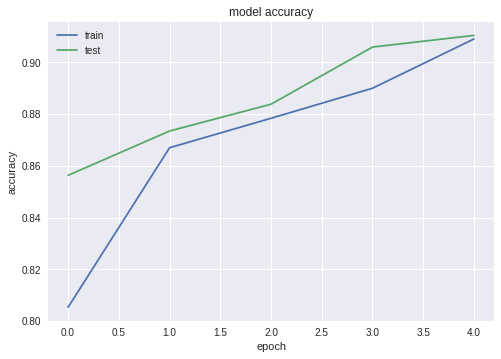

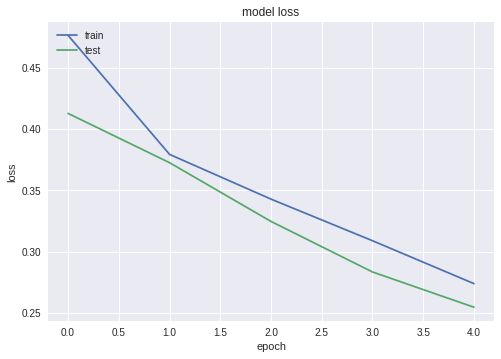

(None, None)

In [0]:
acc_plot(history_v1),loss_plot(history_v1)

### Modelv2

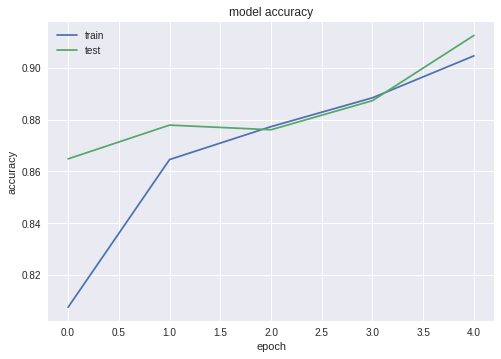

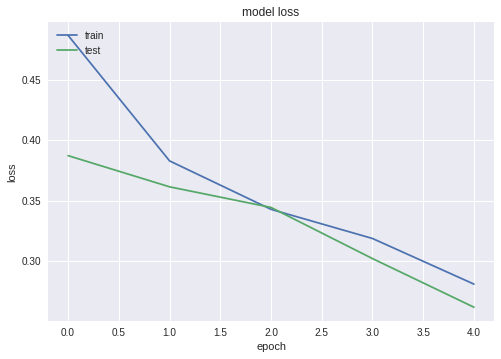

(None, None)

In [0]:
acc_plot(historyv2),loss_plot(historyv2)

### Modelv3

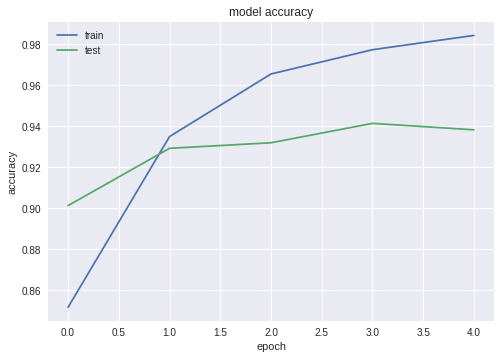

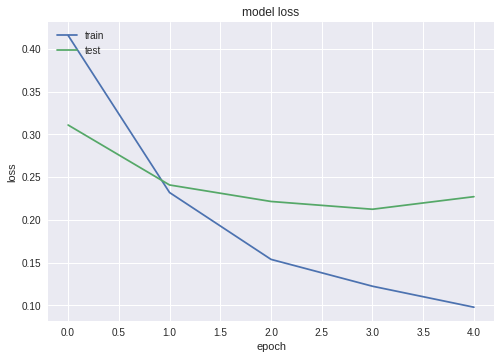

(None, None)

In [0]:
acc_plot(historyv3),loss_plot(historyv3)

### Modelv4

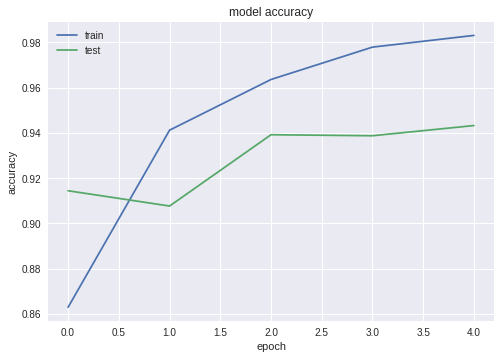

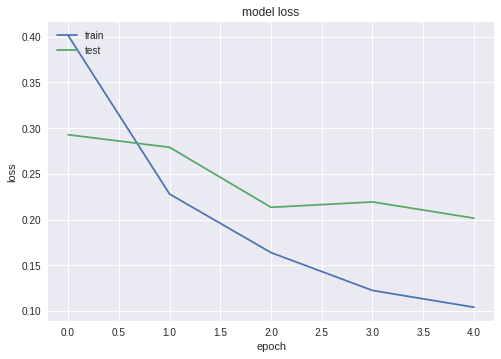

(None, None)

In [0]:
acc_plot(historyv4),loss_plot(historyv4)

In [0]:
def model_eval(msg, model,test_data,test_labels):
  print('Evaluation of: ',msg)
  dash_length = len('Evaluation of Model')
  print('---'*dash_length)
  y_Pred = model.predict(test_data)
  y_Pred = y_Pred[:,0] > 0.5
  y_Test = test_labels[:,0] > 0.5
  cm = confusion_matrix(y_Test, y_Pred)
  print(cm)
  print(classification_report(y_Test, y_Pred, target_names=['Real', 'Fake']))
  print('---'*dash_length)

In [0]:
model_eval('Modelv1',modelv1,xTest,yTest)
model_eval('Modelv2',modelv2,xTest,yTest)
model_eval('Modelv3',modelv3,xTest,yTest)
model_eval('Modelv4',modelv4,xTest,yTest)

Evaluation of:  Modelv1
---------------------------------------------------------
[[ 978   94]
 [ 105 1043]]
              precision    recall  f1-score   support

        Real       0.90      0.91      0.91      1072
        Fake       0.92      0.91      0.91      1148

   micro avg       0.91      0.91      0.91      2220
   macro avg       0.91      0.91      0.91      2220
weighted avg       0.91      0.91      0.91      2220

---------------------------------------------------------
Evaluation of:  Modelv2
---------------------------------------------------------
[[ 975   97]
 [  97 1051]]
              precision    recall  f1-score   support

        Real       0.91      0.91      0.91      1072
        Fake       0.92      0.92      0.92      1148

   micro avg       0.91      0.91      0.91      2220
   macro avg       0.91      0.91      0.91      2220
weighted avg       0.91      0.91      0.91      2220

---------------------------------------------------------
Evaluation o

# Generalization required.
Work needed to be done to improve model performance.